# 1. Environment Setup

In [49]:
%pip install urllib3 xarray numpy pandas tqdm pillow matplotlib plotly seaborn scikit-learn netCDF4 h5netcdf


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [50]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Data Formatting
import urllib.request
import xarray as xr
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import os
from PIL import Image

import netCDF4
import h5netcdf

# Data Viz
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Data Processing
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. PCA Model

$$\text{Original Components} = \text{Height x Width x Number of Channels}$$
$$\text{PCA Components} = n_{\text{components}}$$
$$\text{Reduction Ratio} = \frac{n_{\text{pca}}}{n_{\text{original}}}$$

# 2. Regression (Precipitation Forcasting)



In [51]:
# Data formatting and importing
image_dir = 'monthly_precipitation_maps'
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
dates = [f.split('_')[1].split('.')[0] for f in image_files]

# Convert dates to numerical format (e.g., YYYYMM to integer)
date_objects = [datetime.strptime(date, "%Y-%m-%d") for date in dates]

def load_images(image_dir, image_files):
    images = []
    for file in tqdm(image_files):
        img_path = os.path.join(image_dir, file)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((500, 350))  # Resize images to match input size of CNN
        img_array = np.array(img) / 255.0 # Normalize pixel values
        images.append(img_array)
    return np.array(images)

X_precipitation = load_images(image_dir, image_files)

100%|██████████| 72/72 [00:01<00:00, 54.39it/s]


In [52]:
# IGNORE: train-test splitting indexes
train_indices = [i for i, dt in enumerate(date_objects) if dt.year < 2015]
test_indices = [i for i, dt in enumerate(date_objects) if dt.year == 2015]

X_train_precipitation = X_precipitation[train_indices]
X_test_precipitation = X_precipitation[test_indices]

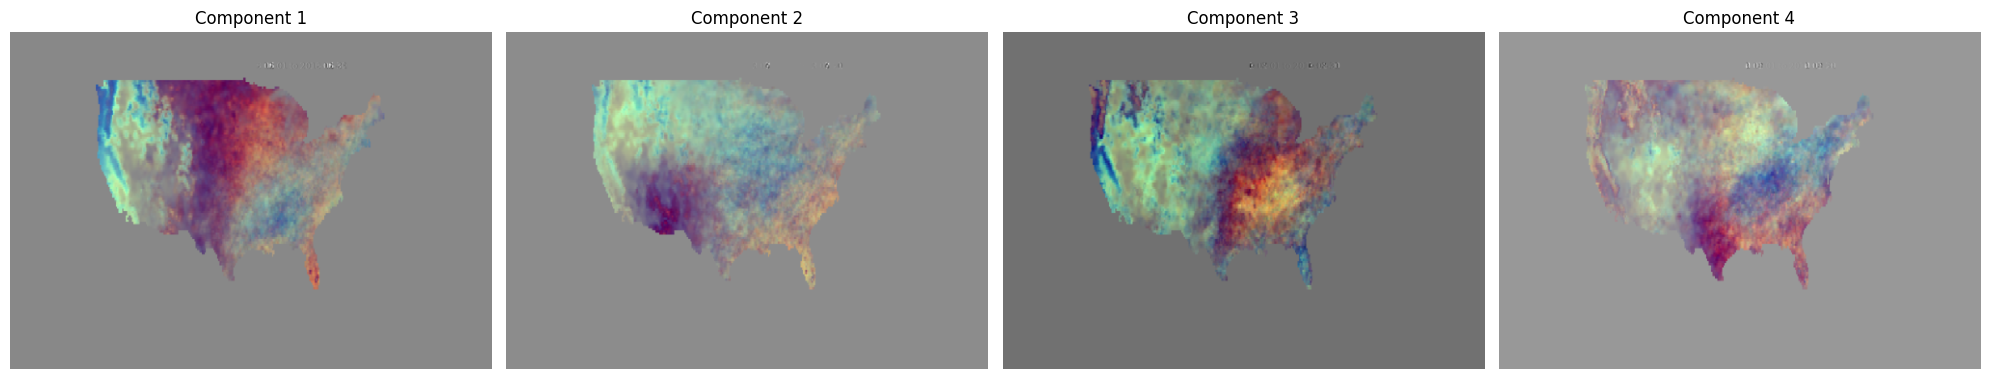

In [53]:
# Reshape images for PCA
n_samples_train, height, width, channels = X_train_precipitation.shape
X_train_precipitation_flattened = X_train_precipitation.reshape(n_samples_train, -1)

# Train first 4 components
pca_precipitation = PCA(n_components=4)
pca_precipitation.fit(X_train_precipitation_flattened)

# Flatten test images
n_samples_test = X_test_precipitation.shape[0]
X_test_precipitation_flattened = X_test_precipitation.reshape(n_samples_test, -1)

# Transform with the trained PCA
X_test_precipitation_pca = pca_precipitation.transform(X_test_precipitation_flattened)
components = pca_precipitation.components_.reshape(4, height, width, channels)

# Plot all PCA components
fig, axes = plt.subplots(1, 4, figsize=(20, 5), facecolor='w')
for i, ax in enumerate(axes):
    # Normalize the component values for visualization
    component_image = components[i] - components[i].min()
    component_image /= component_image.max()
    
    ax.imshow(component_image, cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Component {i + 1}')
plt.tight_layout()
plt.show()

# 3. Classification (MNIST)

In [54]:
# Load and preprocess the MNIST data
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

# Normalize Data
x_train_mnist_normalized = x_train_mnist / 255.0
x_test_mnist_normalized = x_test_mnist / 255.0 

# Flatten for PCA
x_train_flat = x_train_mnist_normalized.reshape(-1, 28 * 28)
x_test_flat = x_test_mnist_normalized.reshape(-1, 28 * 28)

y_train = to_categorical(y_train_mnist)
y_test = to_categorical(y_test_mnist)


In [55]:
# Apply PCA
pca_mnist = PCA(n_components=30) # Principal components: TEST DIFFERENT VALUES
x_train_mnist_pca = pca_mnist.fit_transform(x_train_flat)
x_test_mnist_pca = pca_mnist.transform(x_test_flat)

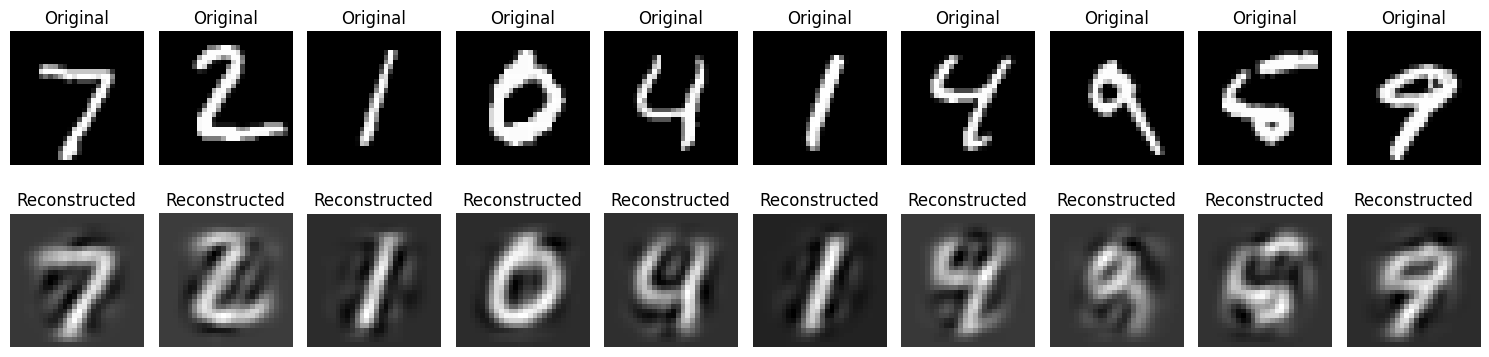

In [56]:
# Visualize reconstructed images from PCA
def plot_reconstructed_images(original, transformed, pca_model, num_images=10):
    """Reconstruct and plot the original and PCA-reconstructed images."""
    reconstructed = pca_model.inverse_transform(transformed)
    reconstructed_images = reconstructed.reshape(-1, 28, 28)

    fig, axes = plt.subplots(2, num_images, figsize=(15, 4))
    for i in range(num_images):
        # Original images
        axes[0, i].imshow(original[i], cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        # Reconstructed images
        axes[1, i].imshow(reconstructed_images[i], cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot original and reconstructed images
plot_reconstructed_images(x_test_mnist, x_test_mnist_pca, pca_mnist)

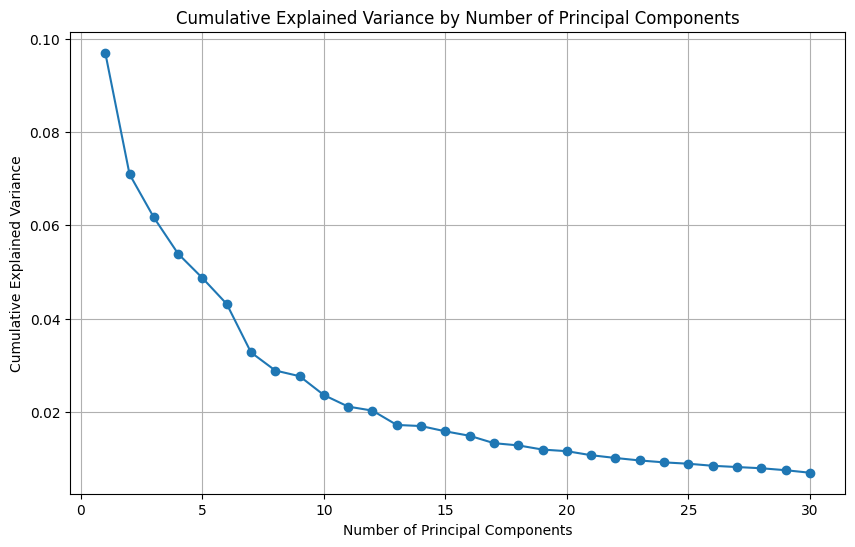

In [57]:
# Explained variance plot
explained_variance_ratio = pca_mnist.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(range(1, 30 + 1), explained_variance_ratio, marker='o')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [58]:
rf_original = RandomForestClassifier(n_estimators=100, random_state=42)
rf_original.fit(x_train_flat, y_train)
y_pred_orig = rf_original.predict(x_test_flat)

accuracy_orig = accuracy_score(y_test, y_pred_orig)
print("Random Forest Accuracy on Original Data:", accuracy_orig)

Random Forest Accuracy on Original Data: 0.9056


In [59]:
rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pca.fit(x_train_mnist_pca, y_train)
y_pred_pca = rf_pca.predict(x_test_mnist_pca)

accuracy_pca = accuracy_score(y_test, y_pred_pca)
print("Random Forest Accuracy on PCA-Compressed Data:", accuracy_pca)

Random Forest Accuracy on PCA-Compressed Data: 0.8701
